In [10]:
import os

from dotenv import find_dotenv, load_dotenv

In [11]:
load_dotenv(find_dotenv('.env'))

True

In [12]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 1 (Overview)"

![](images/rag.png)

# Part 1: Overview

![](images/01-01-overview.png)

![](images/01-02-overview.png)

## Configure components

In [13]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [14]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BKMvWXqejr2sHYneYvd4Sr6SbRKv0', 'finish_reason': 'stop', 'logprobs': None}, id='run-f1bd73da-f189-46b5-8fab-aa082cf98064-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [15]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [16]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

In [17]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

1

In [18]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

## Split documents

In [19]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [20]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
len(splits)

66

## Store documents

In [21]:
from langchain_core.vectorstores import InMemoryVectorStore

In [22]:
vectorstore = InMemoryVectorStore(embeddings)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

(66, 66)

## RAG

In [23]:
from typing import TypedDict

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langgraph.graph import END, START, StateGraph

In [24]:
rag_prompt_template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:"""
print(rag_prompt_template)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [25]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [26]:
class State(TypedDict):
    question: str
    context: list[Document]
    answer: str

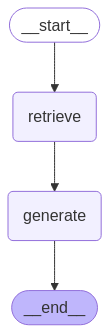

In [27]:
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = format_docs(state["context"])
    rag_prompt = rag_prompt_template.format(
        question=state["question"],
        context=docs_content
    )
    response = llm.invoke([
        HumanMessage(content=rag_prompt)
    ])
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("generate", END)
graph = graph_builder.compile()
graph

In [28]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition is the process of breaking down a complex task into smaller, manageable steps or subgoals. This can be achieved through various methods, including prompting a language model, using task-specific instructions, or incorporating human inputs. It enhances the model's performance by allowing it to tackle each component systematically.
